In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

In [91]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier

Data engineering - creating element wise data for each score

In [4]:
data = pd.read_csv('mu_data.csv')
data.head()

,id,Polls ID,Assessment reports Student ID,Poll Responses Response,Assessment reports Hashtag,Assessment reports Score
0,1,12522.0,41.0,The strengths of Plato's approach is his const...,#objectivemorality,2.0
1,2,12522.0,42.0,Having a difficulty with his Divided Line. Th...,#deductivearg,2.0
2,3,12522.0,44.0,"How can one know if he's in the cave or not, i...",#objectivemorality,3.0
3,4,12522.0,237.0,S: the hierarchy of the chart we filled out at...,#objectivemorality,3.0
4,5,12522.0,239.0,It is difficult to grasp how to apply Plato's ...,#objectivemorality,3.0


In [5]:
data = data.rename(columns={
    'Polls ID': 'poll_id',
    'Assessment reports Student ID': 'student_id',
    'Poll Responses Response':'response',
    'Assessment reports Hashtag':'HC',
    'Assessment reports Score':'score'})
data.head()

,id,poll_id,student_id,response,HC,score
0,1,12522.0,41.0,The strengths of Plato's approach is his const...,#objectivemorality,2.0
1,2,12522.0,42.0,Having a difficulty with his Divided Line. Th...,#deductivearg,2.0
2,3,12522.0,44.0,"How can one know if he's in the cave or not, i...",#objectivemorality,3.0
3,4,12522.0,237.0,S: the hierarchy of the chart we filled out at...,#objectivemorality,3.0
4,5,12522.0,239.0,It is difficult to grasp how to apply Plato's ...,#objectivemorality,3.0


In [6]:
deduction = data[data['HC'] == '#deduction']
deduction.shape
deduction.head()

,id,poll_id,student_id,response,HC,score
263,264,19704.0,283.0,Freshwater economists would state that the bub...,#deduction,4.0
626,627,20862.0,625.0,The most important moment of class for me was ...,#deduction,3.0
627,628,20862.0,634.0,"Free choice can be manipulated with language, ...",#deduction,3.0
628,629,20862.0,653.0,The activities regarding quantifiers placed a ...,#deduction,3.0
629,630,20862.0,673.0,Applying quantifiers that eliminate the ambigu...,#deduction,3.0


In [7]:
"""
Rubric for #deduction
1. Accurately applies and analyzes deductive reasoning with clear and detailed explanation
2. accurately identifies premises and conclusions and justifies the identification
3. provides a detailed, well-justified evaluation of the relationships among propositions with easy to follow steps
4. accurately distinguishes between validity and soundness and explains the meaning of each in the given context
5. provides a detailed, well justified evaluation of the validity or soundness
6. accurately and effectively applies deductive techniques to a complex, sophisticated derivation.

Assuming that a person gets a 4 if they applied at least half of these, 3 if they applied 2, 2 if they applied 1 
"""

'\nRubric for #deduction\n1. Accurately applies and analyzes deductive reasoning with clear and detailed explanation\n2. accurately identifies premises and conclusions and justifies the identification\n3. provides a detailed, well-justified evaluation of the relationships among propositions with easy to follow steps\n4. accurately distinguishes between validity and soundness and explains the meaning of each in the given context\n5. provides a detailed, well justified evaluation of the validity or soundness\n6. accurately and effectively applies deductive techniques to a complex, sophisticated derivation.\n\nAssuming that a person gets a 4 if they applied at least half of these, 3 if they applied 2, 2 if they applied 1 \n'

In [8]:
deduction = deduction.drop(['id', 'student_id', 'HC'], axis = 1)


In [44]:
total_elements = 6
rubric = np.zeros((2977, 6))
i = 0
for score in deduction['score']:
    if score == 4.0:
        #gets a 4 if they met 4, 5, or all 6 of the elements
        c = np.random.randint(4,7)
        elemets = [0]*(total_elements-c) + [1]*(c)
        np.random.shuffle(elemets)
        rubric[i] = elemets
    elif score == 3.0:
        #gets a 3 if they met 2 or 3 of the elements
        c = np.random.randint(2, 4)
        elemets = [0]*(total_elements - c) + [1]*(c)
        np.random.shuffle(elemets)
        rubric[i] = elemets
        rubric[i] = elemets
    elif score == 2.0:
        #gets a 2 if they met 1 or 2 of the elements
        c = np.random.randint(1, 3)
        elemets = [0]*(total_elements-c) + [1]*(c)
        np.random.shuffle(elemets)
        rubric[i] = elemets
        rubric[i] = elemets
    i += 1

#np.random.randint(2, size = (10, 6))


In [57]:
rubric_elements = pd.DataFrame(rubric)
rubric_elements = rubric_elements.rename(columns={
    0: 'E1',
    1: 'E2',
    2: 'E3',
    3: 'E4',
    4: 'E5',
    5: 'E6'})
rubric_elements.head()

,E1,E2,E3,E4,E5,E6
0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0


In [68]:
deduction = deduction.reset_index()
deduction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   level_0   2977 non-null   int64  
 1   index     2977 non-null   int64  
 2   poll_id   2977 non-null   float64
 3   response  2977 non-null   object 
 4   score     2977 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 116.4+ KB


In [71]:
 deduction = deduction.join(rubric_elements, how='right') 

Training a model

In [75]:
X = deduction[['E1', 'E2', 'E3', 'E4', 'E5', 'E6']].values
y = deduction['score'].values

#splitting the data into testing and training data to test for accuracy 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 35)

In [78]:
model = SVC(C = 8)
model.fit(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f'Support Vector Classifier test accuracy {test_score:.3}')

Support Vector Classifier test accuracy 0.858


#### Hyperparameter tuning

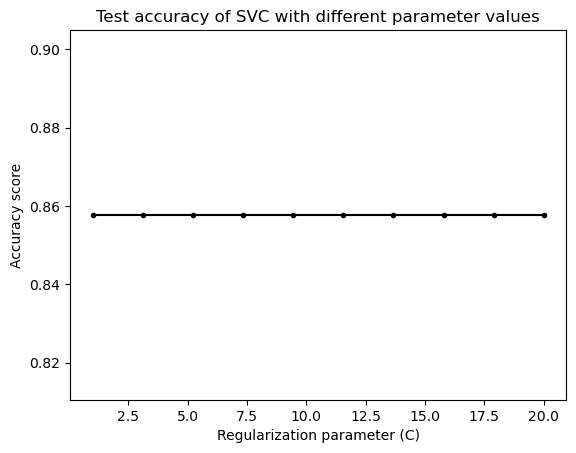

In [79]:
C = np.linspace(1, 20, 10)
scores = []

for c in C:
    model = SVC(C = c)
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    scores.append(test_score)
    
plt.figure()
plt.plot(C, scores, marker = '.', color = 'black')
plt.ylabel('Accuracy score')
plt.xlabel('Regularization parameter (C)')
plt.title('Test accuracy of SVC with different parameter values')
plt.show()

In [81]:
#tuning for only one parameter doesn't give us very credible results so I use Cross validation to tune for several paramters.
kf = KFold(n_splits = 5, shuffle = True, random_state=43)
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

svm = SVC()
svm_cv = GridSearchCV(svm, param_grid, cv = kf)
svm_cv.fit(X_train, y_train)
print(svm_cv.best_params_, svm_cv.best_score_)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'} 0.8812792809060903


Trying other models

In [92]:
models = {'KNN': KNeighborsClassifier(n_neighbors = 8), 'Random Forest': RandomForestClassifier(), 'SVC': SVC()}
#calculating the inital model accuracy for each model, before parameter tuning 
for name, model in models.items():
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f'{name} test accuracy {test_score:.3}')

KNN test accuracy 0.828
Random Forest test accuracy 0.858
SVC test accuracy 0.858


In [93]:
#corss validation
kf = KFold(n_splits = 5, shuffle = True, random_state=43)
param_grid = {'leaf_size': np.arange(1, 50), 'n_neighbors':np.arange(1, 30), 'p':[1,2]}

KNN = KNeighborsClassifier()
KNN_cv = GridSearchCV(KNN, param_grid, cv = kf)
KNN_cv.fit(X_train, y_train)
print(KNN_cv.best_params_, KNN_cv.best_score_)

{'leaf_size': 14, 'n_neighbors': 7, 'p': 1} 0.8718702661490154
